In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from catboost.utils import get_roc_curve
import xgboost as xgb
import lightgbm as lgb
import catboost as catb

****************

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
df_train = reduce_mem_usage(pd.read_csv('assignment_2_train.csv'))
df_test = reduce_mem_usage(pd.read_csv('assignment_2_test.csv'))

Memory usage of dataframe is 541.08 MB
Memory usage after optimization is: 262.48 MB
Decreased by 51.5%
Memory usage of dataframe is 300.60 MB
Memory usage after optimization is: 145.82 MB
Decreased by 51.5%


In [5]:
df_train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: category(14), float32(376), int16(1), int32(2), int8(1)
memory usage: 262.5 MB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Columns: 394 entries, TransactionID to V339
dtypes: category(14), float32(376), int16(1), int32(2), int8(1)
memory usage: 145.8 MB


In [8]:
df_train['isFraud'].value_counts()

0    174859
1      5141
Name: isFraud, dtype: int64

In [9]:
X_train = df_train.drop(columns='isFraud')
y_train = df_train['isFraud']
X_valid = df_test.drop(columns='isFraud')
y_valid = df_test['isFraud']

**Задание 1:** отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [10]:
#  можно было из чиловых добавить категорий, но тогда первое задание по-другому должно звучать
categorical_features = df_train.select_dtypes(
    include=['category']).columns.tolist()
print(f'Количество категориальоных признаков - {len(categorical_features)}')

Количество категориальоных признаков - 14


In [11]:
numerical_features = df_train.select_dtypes(
    include=[np.number]).columns.tolist()
numerical_features = list(set(numerical_features)-set(categorical_features))
numerical_features.remove('isFraud')

In [12]:
features_sel = numerical_features
train_xgb_num = xgb.DMatrix(data=X_train[features_sel], label=y_train)
valid_xgb_num = xgb.DMatrix(data=X_valid[features_sel], label=y_valid)

In [13]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": -1,
    "seed": 13
}

In [14]:
model_xgb_num = xgb.train(
    params=params,
    dtrain=train_xgb_num,
    num_boost_round=500,
    early_stopping_rounds=50,
    evals=[(train_xgb_num, "train"), (valid_xgb_num, "valid")],
    verbose_eval=50,
    maximize=True,
)

[0]	train-auc:0.64999	valid-auc:0.62240
[50]	train-auc:0.88294	valid-auc:0.85164
[100]	train-auc:0.90027	valid-auc:0.85605
[150]	train-auc:0.90812	valid-auc:0.85826
[200]	train-auc:0.91238	valid-auc:0.85984
[231]	train-auc:0.91238	valid-auc:0.85984


**Задание 2:** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [15]:
train_len = len(df_train)
dataset = pd.concat(objs=[X_train, X_valid], axis=0)
dataset = pd.get_dummies(dataset)
dum_train = dataset[:train_len].copy() # dummies
dum_test = dataset[train_len:].copy() # dummies

In [16]:
train_xgb_cat = xgb.DMatrix(data=dum_train,
                            label=y_train,
                            enable_categorical=True
                            )

valid_xgb_cat = xgb.DMatrix(data=dum_test,
                            label=y_valid,
                            enable_categorical=True
                            )

In [17]:
model_xgb_cat = xgb.train(
    params=params,
    dtrain=train_xgb_cat,
    num_boost_round=500,
    early_stopping_rounds=50,
    evals=[(train_xgb_cat, "train"), (valid_xgb_cat, "valid")],
    verbose_eval=50,
    maximize=True,
)

[0]	train-auc:0.64999	valid-auc:0.62240
[50]	train-auc:0.88709	valid-auc:0.85710
[100]	train-auc:0.90886	valid-auc:0.86272
[150]	train-auc:0.91683	valid-auc:0.86575
[200]	train-auc:0.91790	valid-auc:0.86629
[210]	train-auc:0.91790	valid-auc:0.86629


*******************************

**Задание 4:** для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [18]:
params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": -1,
    "seed": 13
}

In [19]:
features_sel = numerical_features
train_lgb_num = lgb.Dataset(X_train[features_sel], y_train)
valid_lgb_num = lgb.Dataset(X_valid[features_sel], y_valid)

In [20]:
model_lgbm_num = lgb.train(
    params=params,
    train_set=train_lgb_num,
    num_boost_round=10000,
    valid_sets=[train_lgb_num, valid_lgb_num],
    categorical_feature="auto",
    early_stopping_rounds=100,
    verbose_eval=250
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32181
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 377
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	training's auc: 0.898265	valid_1's auc: 0.856568


**Задание 5:** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [21]:
train_lgb_cat = lgb.Dataset(dum_train, y_train)
valid_lgb_cat = lgb.Dataset(dum_test, y_valid)

In [22]:
model_lgbm_cat = lgb.train(
    params=params,
    train_set=train_lgb_cat,
    num_boost_round=10000,
    valid_sets=[train_lgb_cat, valid_lgb_cat],
    categorical_feature="auto",
    early_stopping_rounds=100,
    verbose_eval=250
)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32429
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 501
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 100 rounds
[250]	training's auc: 0.923479	valid_1's auc: 0.867132
[500]	training's auc: 0.947262	valid_1's auc: 0.874316
[750]	training's auc: 0.96034	valid_1's auc: 0.877278
Early stopping, best iteration is:
[866]	training's auc: 0.964124	valid_1's auc: 0.87

**Задание 6:** обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [23]:
train_lgb_cat_2 = lgb.Dataset(X_train, y_train)
valid_lgb_cat_2 = lgb.Dataset(X_valid, y_valid)

In [24]:
model_lgbm_cat_2 = lgb.train(
    params=params,
    train_set=train_lgb_cat_2,
    num_boost_round=10000,
    valid_sets=[train_lgb_cat_2, valid_lgb_cat_2],
    categorical_feature=categorical_features,
    early_stopping_rounds=100,
    verbose_eval=250
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.349593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32346
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 391
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 100 rounds
[250]	training's auc: 0.92395	valid_1's auc: 0.864511
[500]	training's auc: 0.948332	valid_1's auc: 0.872369
[750]	training's auc: 0.9615	valid_1's auc: 0.875245
[1000]	training's auc: 0.968927	valid_1's auc: 0.876221
Early stopping, best iteration is:
[912]	training's auc: 0.966524	valid_1's auc: 0.876337


Без настройки гиперпараметров - здесь что-то уже близкое к  переобучению. Существенной разницы в подходах не наблюдается

******************************

**Задание 7:** для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [25]:
params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "learning_rate": 0.1,
    "max_bin": 20,
    "verbose": 200,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 6,
    "random_seed": 13
}

In [26]:
features_sel = numerical_features

train_catb_num = catb.Pool(X_train[features_sel], y_train)
valid_catb_num = catb.Pool(X_valid[features_sel], y_valid)

In [27]:
model_catb_num = catb.CatBoostClassifier(**params)
model_catb_num.fit(train_catb_num, eval_set=valid_catb_num)

0:	test: 0.5968017	best: 0.5968017 (0)	total: 223ms	remaining: 37m 13s
200:	test: 0.8546730	best: 0.8556883 (167)	total: 17.1s	remaining: 13m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8556883036
bestIteration = 167

Shrink model to first 168 iterations.


**Задание 8:** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [28]:
train_catb_cat = catb.Pool(dum_train, y_train)
valid_catb_cat = catb.Pool(dum_test, y_valid)

In [29]:
model_catb_cat = catb.CatBoostClassifier(**params)
model_catb_cat.fit(train_catb_cat, eval_set=valid_catb_cat)

0:	test: 0.5612009	best: 0.5612009 (0)	total: 84.5ms	remaining: 14m 4s
200:	test: 0.8604995	best: 0.8608282 (171)	total: 17.2s	remaining: 14m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8608281571
bestIteration = 171

Shrink model to first 172 iterations.


**Задание 9:** обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [30]:
X_train_catb = X_train.copy()
X_valid_catb = X_valid.copy()

In [31]:
for feature in categorical_features:
    X_train_catb[feature] = X_train_catb[feature].cat.add_categories(['unk'])
    X_train_catb[feature] = X_train_catb[feature].fillna('unk')
    X_train_catb[feature] = X_train_catb[feature].astype('str')

    X_valid_catb[feature] = X_valid_catb[feature].cat.add_categories(['unk'])
    X_valid_catb[feature] = X_valid_catb[feature].fillna('unk')
    X_valid_catb[feature] = X_valid_catb[feature].astype('str')

In [32]:
train_catb_cat_2 = catb.Pool(
    X_train_catb, y_train, cat_features=categorical_features)
valid_catb_cat_2 = catb.Pool(
    X_valid_catb, y_valid, cat_features=categorical_features)

In [33]:
model_catb_cat_2 = catb.CatBoostClassifier(**params)
model_catb_cat_2.fit(train_catb_cat_2, eval_set=valid_catb_cat_2)

0:	test: 0.6578656	best: 0.6578656 (0)	total: 444ms	remaining: 1h 14m 2s
200:	test: 0.8603735	best: 0.8607388 (171)	total: 1m 16s	remaining: 1h 1m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8607388088
bestIteration = 171

Shrink model to first 172 iterations.


Показатели примерно одинаковые

************************

**Задание 10:** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

In [34]:
model_dict = {"xgb_num": model_xgb_num,
              "xgb_cat": model_xgb_cat,
              "lgb_num": model_lgbm_num,
              "lgb_cat": model_lgbm_cat,
              "lgb_cat_lgb": model_lgbm_cat_2,
              }

train_data_list = [train_xgb_num,
                   train_xgb_cat,
                   X_train[numerical_features],
                   dum_train,
                   X_train,
                   ]

test_data_list = [valid_xgb_num,
                  valid_xgb_cat,
                  df_test[numerical_features],
                  dum_test,
                  X_valid
                  ]

In [35]:
def roc_params(model, df, y_true):
    pred_proba_train = model.predict(df)
    fpr, tpr, _ = roc_curve(y_true, pred_proba_train)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

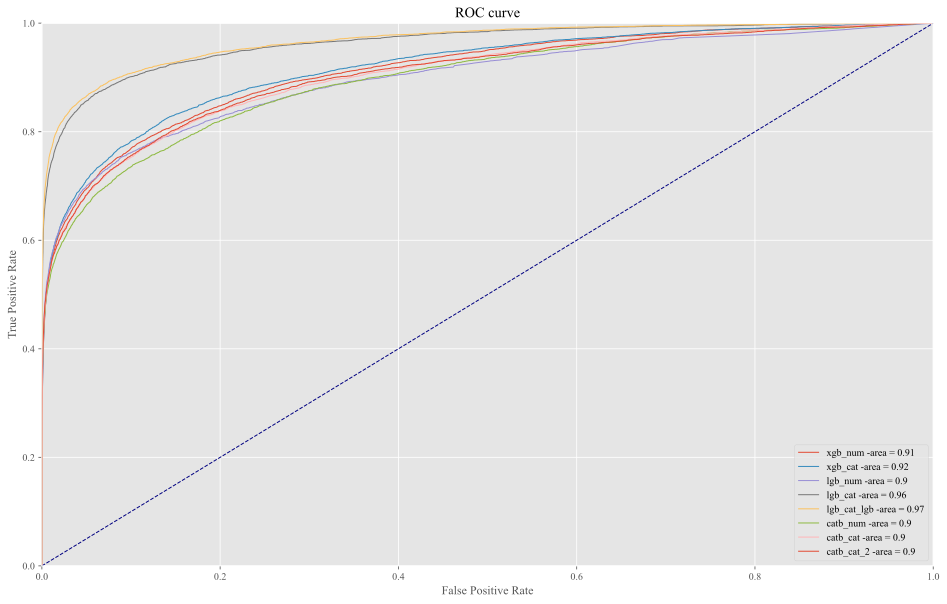

In [36]:
plt.figure(figsize=(16, 10))
plt.title('TRAIN ROC-AUC RESULTS')

for num, model in enumerate(model_dict):
    fpr, tpr, roc_auc = roc_params(
        model_dict[model], train_data_list[num], y_train)
    plt.plot(fpr, tpr, lw=1, label=f'{model} -area = {round(roc_auc, 2)}')

fpr, tpr, thresholds = get_roc_curve(model_catb_num, train_catb_num, plot=False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label=f'catb_num -area = {round(roc_auc, 2)}')

fpr, tpr, thresholds = get_roc_curve(model_catb_cat, train_catb_cat, plot=False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label=f'catb_cat -area = {round(roc_auc, 2)}')

fpr, tpr, thresholds = get_roc_curve(model_catb_cat_2, train_catb_cat_2, plot=False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label=f'catb_cat_2 -area = {round(roc_auc, 2)}')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

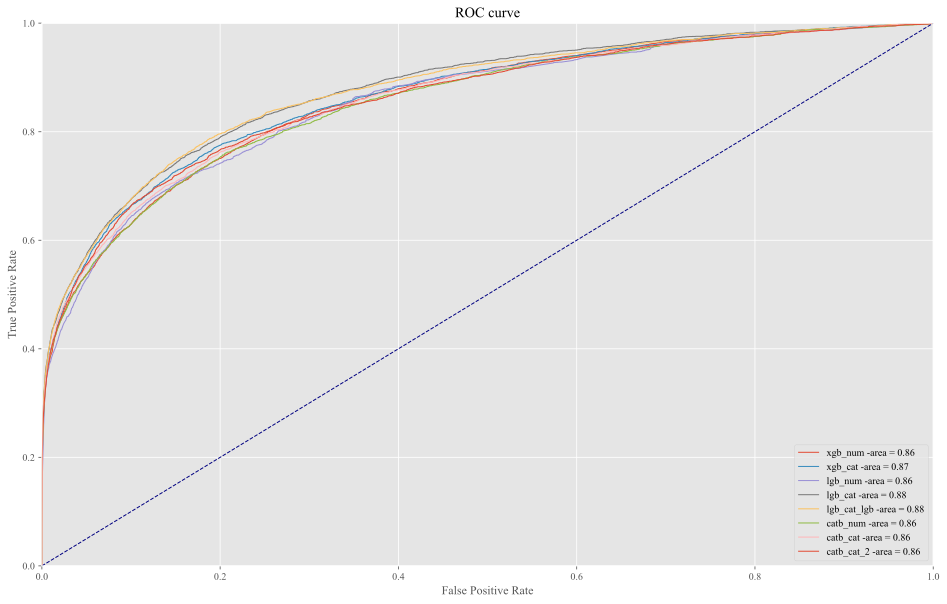

In [37]:
plt.figure(figsize=(16, 10))
plt.title('TEST ROC-AUC RESULTS')

for num, model in enumerate(model_dict):
    fpr, tpr, roc_auc = roc_params(
        model_dict[model], test_data_list[num], y_valid)
    plt.plot(fpr, tpr, lw=1, label=f'{model} -area = {round(roc_auc, 2)}')

fpr, tpr, thresholds = get_roc_curve(model_catb_num, valid_catb_num, plot=False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label=f'catb_num -area = {round(roc_auc, 2)}')

fpr, tpr, thresholds = get_roc_curve(model_catb_cat, valid_catb_cat, plot=False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label=f'catb_cat -area = {round(roc_auc, 2)}')

fpr, tpr, thresholds = get_roc_curve(model_catb_cat_2, valid_catb_cat_2, plot=False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label=f'catb_cat_2 -area = {round(roc_auc, 2)}')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Нет особого смысла сравнивать качество моделей, если не было подбора гиперпараметров. метрика ROС-AUC не подходит для сильного дисбаланса классов (для этого лучше подходит PR или f1-score минорного класса). А здесь он сильный. Собствнно поэтому склонность ligtgbm к переобучению при заданных параметрах, не сильно заметна на тесте - там все модели показали прмерно +- схожий результат.